In [ ]:
#pwd
#cd ~Desktop/covid_machinations

In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [3]:
# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

import numpy as np
import pandas as pd
import openpyxl

In [16]:
# This code was used when repeatedly modifying date_checker module
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [17]:
# Custom pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.display import Image
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-15'

### The following cell determines if the Colorado site has been updated

In [5]:
# outbreaks files are updated on the web once a week usually Wed afternoon
# date_checker is a custom python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()


# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2021-04-07
COVID-19 OB Weekly Report 04 14 2021.xlsx
https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2004%2014%202021.xlsx
Site UPDATED! current date of spreadsheet is 2021-04-14
OK to continue


In [6]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2004%2014%202021.xlsx
2021-04-14 00:00:00


### Colorado Outbreak data

In [7]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [8]:
ls

ColoradoOutbreaks.ipynb  covid.ipynb              pie_dict.py*
LICENSE                  covid_data/              state_country_dicts.py
README.md                covid_data_update/       style-notebook.css
Untitled.ipynb           date_checker.py*         style-table.css
__pycache__/             environment.yml


In [9]:
ls covid_data_update/

us_2021-04-15.png                     world_2021-04-15.png
us_AZ_last_60_days_2021-04-15.png     world_FR_last_60_days_2021-04-15.png
us_AZ_last_90_days_2021-04-15.png     world_FR_last_90_days_2021-04-15.png
us_rolling_avg_2021-04-15.png         world_rolling_avg_2021-04-15.png


In [10]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [11]:
df = get_weekly_report(names)
df.shape

(678, 65)

In [12]:
df = df.iloc[:,:16]
df.head(3)

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,10 Barrel,Active,NaN,Bar/Tavern/Brewery,NaN,NaN,Denver,2021-04-02,NaN,6.0,NaN,NaN,NaN,NaN,6,0
1,287 S Starwood Rd Construction Site,Active,NaN,Construction Site,residential construction site,Yes,Pitkin,2020-07-30,NaN,17.0,NaN,NaN,NaN,NaN,17,0
2,3STEP Lacrosse,Active,NaN,Youth Sports/Activities,NaN,NaN,Denver,2021-03-27,NaN,5.0,NaN,NaN,NaN,NaN,5,0


In [13]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [14]:
df = polish_report(df)
# Sanity Check!!!
df.sort_index(ascending=False).head(10)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-14,3,Colorado School of Mines- Alpha Tau Omega,College/University,Jefferson,0,0,3
2021-04-14,2,Dutch Creek Elementary School: April 2021,School K-12,Jefferson,0,0,2
2021-04-14,2,Ostara Co-Op,Other,Boulder,2,0,0
2021-04-14,2,Marycrest Assisted Living (2304ST): March 2021,Healthcare - Assisted Living,Denver,0,2,0
2021-04-14,2,The Corner Coin & Jewelry Inc,Retailer,Larimer,0,2,0
2021-04-13,2,Durango North Head Start,Child Care Center,La Plata,0,1,1
2021-04-13,3,Douglas County High School,School K-12,Douglas,0,0,3
2021-04-13,4,Southwest Eye Consultants,Healthcare - Outpatient,La Plata,0,4,0
2021-04-13,3,Social Gathering- Montezuma,Social Gathering,Summit,0,0,3


### outbreaks

In [19]:
# this saves four csv files for easy viewing access even on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')

# total active
print(f'There are {df.shape[0]} outbreak sites and {df.total.sum()} active cases in Colorado')

There are 678 outbreak sites and 21066 active cases in Colorado


In [20]:
# prompt user to select month (default to current month)
# selecting months in the distant past may yield incorrect values
m = input('Select the month by number (update only recent months):') or names[1].month
y = names[1].year
m = int(m)
print(f'Updating df_month for year {y} and month {m}')

Select the month by number (update only recent months): 


Updating df_month for year 2021 and month 4


In [21]:
# dfy is the df for the current year
dfy = df[df.index.year==y].copy()

In [22]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==m].copy()

In [23]:
df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]

In [24]:
df_month.to_csv(f'./covid_data/covid_2021_{m}.txt')

In [25]:
# get number of sites and total cases for the month
s = df_month.shape[0]
t = df_month.total.sum()
print(f'There were an additional {s} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 251 outbreak sites in Colorado this month.
These represent a total of 1155 new cases.


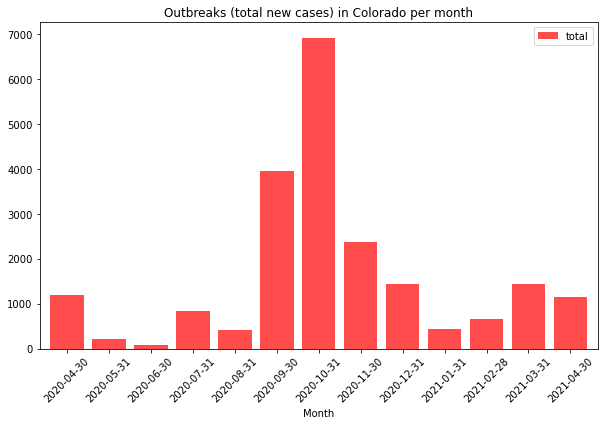

In [26]:
dfm = df.resample('M').sum()
dfm['Month'] = dfm.index.date
dfm

dfm[['Month','total']].plot.bar(figsize=(10,6), \
                                x='Month',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month")
plt.savefig(f'./covid_data_update/outbreaks-per-month-{day}.png');

In [27]:
dfm.sort_index(ascending = False)

,total,residents,staff,attendee,Month
date,,,,,
2021-04-30,1155,80,655,420,2021-04-30
2021-03-31,1437,117,748,572,2021-03-31
2021-02-28,667,20,326,321,2021-02-28
2021-01-31,426,47,163,216,2021-01-31
2020-12-31,1426,446,740,240,2020-12-31
2020-11-30,2374,697,1489,188,2020-11-30
2020-10-31,6911,2148,988,3775,2020-10-31
2020-09-30,3940,0,517,3423,2020-09-30
2020-08-31,415,0,411,4,2020-08-31


In [28]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

There are 3692 active cases in Boulder County


In [29]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-14,2,Ostara Co-Op,Other,Boulder,2,0,0
2021-04-12,5,Moose Lodge Longmont,Social Gathering,Boulder,0,0,5
2021-04-09,4,Complete Releaf,Retailer,Boulder,0,4,0
2021-04-09,5,Best Western Plus Boulder Inn,Hotel/Lodge/Resort,Boulder,0,5,0
2021-04-08,2,Fairview High School,School K-12,Boulder,0,0,2
2021-04-07,4,CrossFit Cielo,Indoor Entertainment/Rec,Boulder,0,1,3
2021-04-06,6,Masala Co-Operative,Other,Boulder,6,0,0
2021-04-05,2,The Peaks Care Center (020391): March 2021\t,Healthcare - Skilled Nursing,Boulder,0,2,0
2021-03-29,2,PowerBack Rehabilitation Lafayette (02U713): M...,Healthcare - Rehab Facility,Boulder,2,0,0


### Create Pie Chart

In [30]:
# total number of active cases
s = df.total.sum()
s

21066

In [31]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

These represent 90% of all outbreak cases


type
College/University                 0.365328
Construction Company/Contractor    0.017184
Distribution Center/Business       0.013102
Food Manufacturing/Packaging       0.018703
Grocery Store                      0.010443
Healthcare - Skilled Nursing       0.011535
Homeless Shelter                   0.019985
Jail                               0.167236
Materials Supplier                 0.011630
Office/Indoor Workspace            0.033039
Other                              0.027865
Religious Facility                 0.010871
Restaurant - Fast Food             0.011440
Retailer                           0.036125
School K-12                        0.079370
State Prison                       0.070113
Name: total, dtype: float64

In [32]:
# custom function from pie_dict 
from pie_dict import pie

In [33]:
df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-14,2,Ostara Co-Op,Other,Boulder,2,0,0
2021-04-14,2,The Corner Coin & Jewelry Inc,Resturant/Retail,Larimer,0,2,0
2021-04-14,2,Dutch Creek Elementary School: April 2021,Day Care/School,Jefferson,0,0,2
2021-04-14,3,Colorado School of Mines- Alpha Tau Omega,College/University,Jefferson,0,0,3
2021-04-14,2,Marycrest Assisted Living (2304ST): March 2021,Healthcare,Denver,0,2,0


In [34]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

"test = df.type.unique()\ntest = np.append(test,['Social Gathering','Travel'])\nlen(test)\n"

In [35]:
df.type.unique()

array(['Other', 'Resturant/Retail', 'Day Care/School',
       'College/University', 'Healthcare', 'Office/Mfg/Dist/Construction',
       'Jail/Prison'], dtype=object)

In [36]:
test = df.type.unique()
if len(test) != 7:
    more_types = [item for item in test if item not in pie_list]
    df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
    print(f'{more_types} were added to the category: Other')
else:
    print('No new types were added to the category: Other')

No new types were added to the category: Other


In [37]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

type
College/University              7696
Day Care/School                 1986
Healthcare                       728
Jail/Prison                     5070
Office/Mfg/Dist/Construction    2250
Other                           1857
Resturant/Retail                1479
Name: total, dtype: int64


21066

In [51]:
cd ..

/Users/edwardterrell/Desktop/covid_machinations


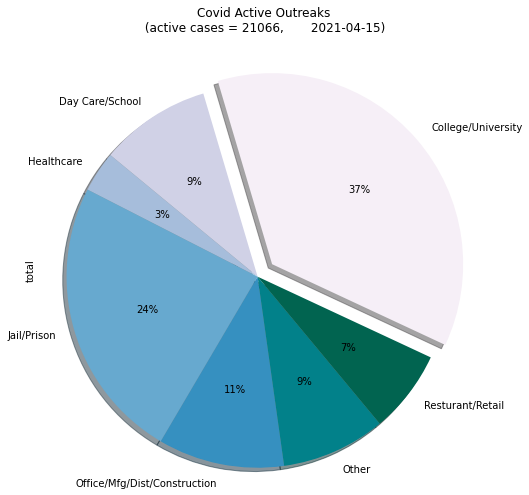

In [52]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

In [60]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [61]:
cd covid_data_update

/Users/edwardterrell/Desktop/covid_machinations/covid_data_update


In [62]:
# Gathering summary statistics for a pie chart of current month
this_month = pd.read_csv('outbreaks-Date-2021-04-15.csv')
this_month.date = pd.to_datetime(this_month.date)
this_month.total = this_month.total.astype(int)

this_month = pie(this_month)
feb = this_month[this_month.date > '2021-03-31'].copy()

In [63]:
feb = feb.groupby('type').total.sum()
this_month_cases = feb.sum()
feb

type
College/University               21
Day Care/School                 420
Healthcare                       98
Jail/Prison                      42
Office/Mfg/Dist/Construction    173
Other                           239
Resturant/Retail                162
Name: total, dtype: int64

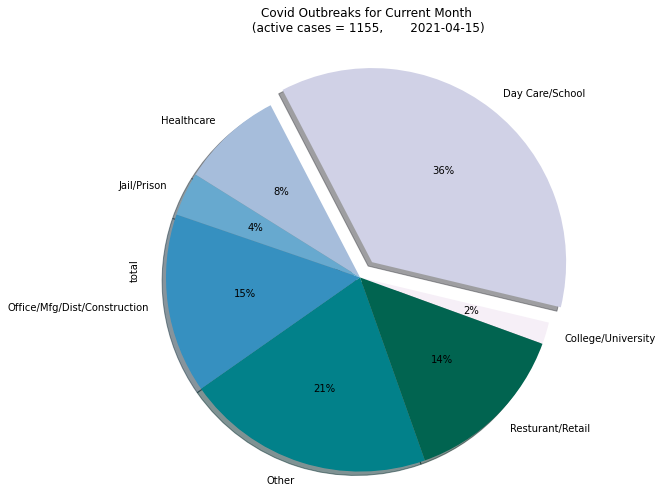

In [65]:
# creates a pie chart of the current month
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (0,.1,0,0,0,0,0)

feb.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%', 
             shadow=True, colors=my_colors,startangle=-20)

plt.title(f'Covid Outbreaks for Current Month\n (active cases = {this_month_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'this_month_outbreaks-piechart-{day}.png');

### Displays all updated graphs files including those from covid.ipynb

In [66]:
!ls -t1 | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text
!ls *.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

In [67]:
png_list

['outbreaks-per-month-2021-04-15.png',
 'outbreaks-piechart-2021-04-15.png',
 'this_month_outbreaks-piechart-2021-04-15.png',
 'us_2021-04-15.png',
 'us_AZ_last_60_days_2021-04-15.png',
 'us_AZ_last_90_days_2021-04-15.png',
 'us_rolling_avg_2021-04-15.png',
 'world_2021-04-15.png',
 'world_FR_last_60_days_2021-04-15.png',
 'world_FR_last_90_days_2021-04-15.png',
 'world_rolling_avg_2021-04-15.png']

In [68]:
from IPython.display import Image

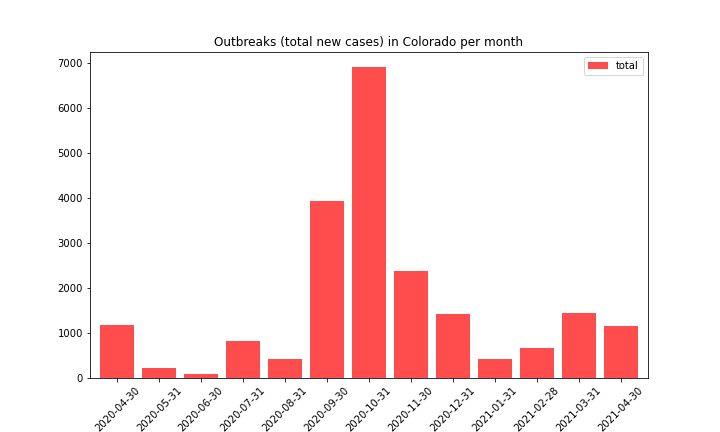

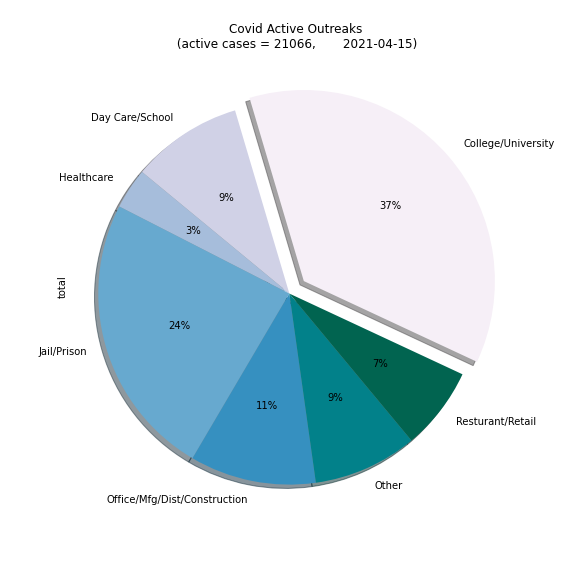

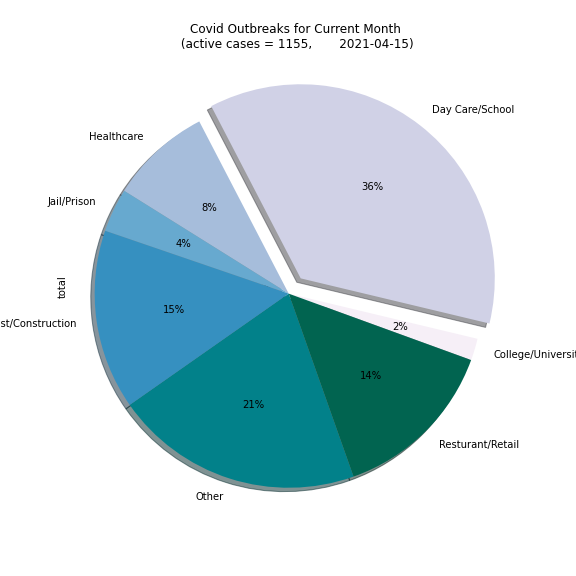

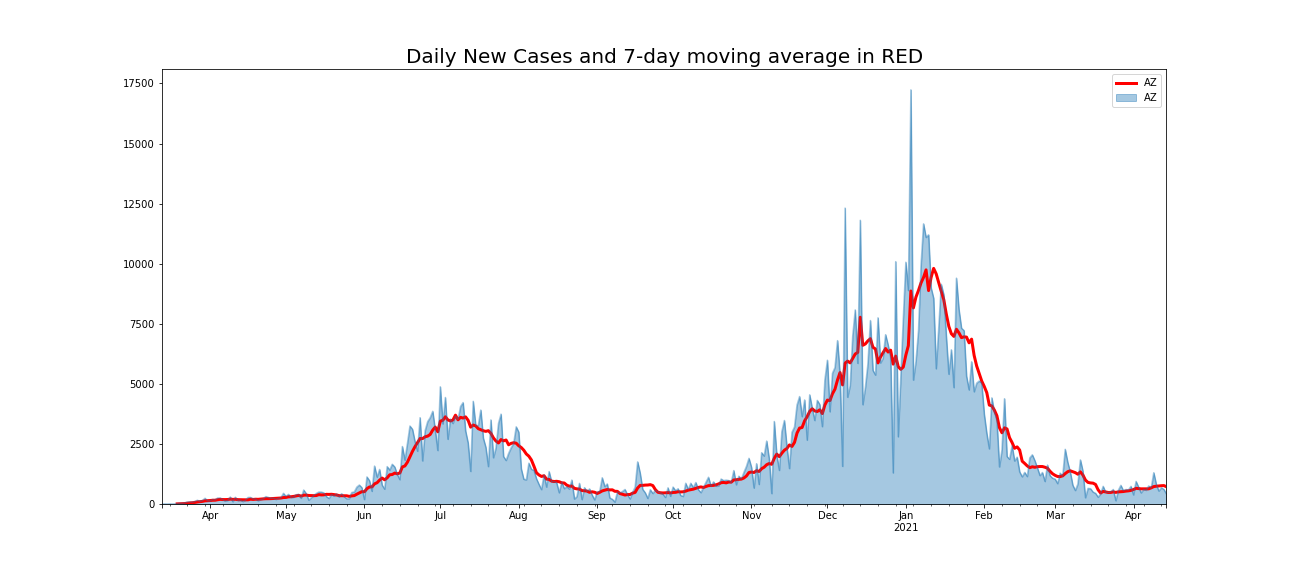

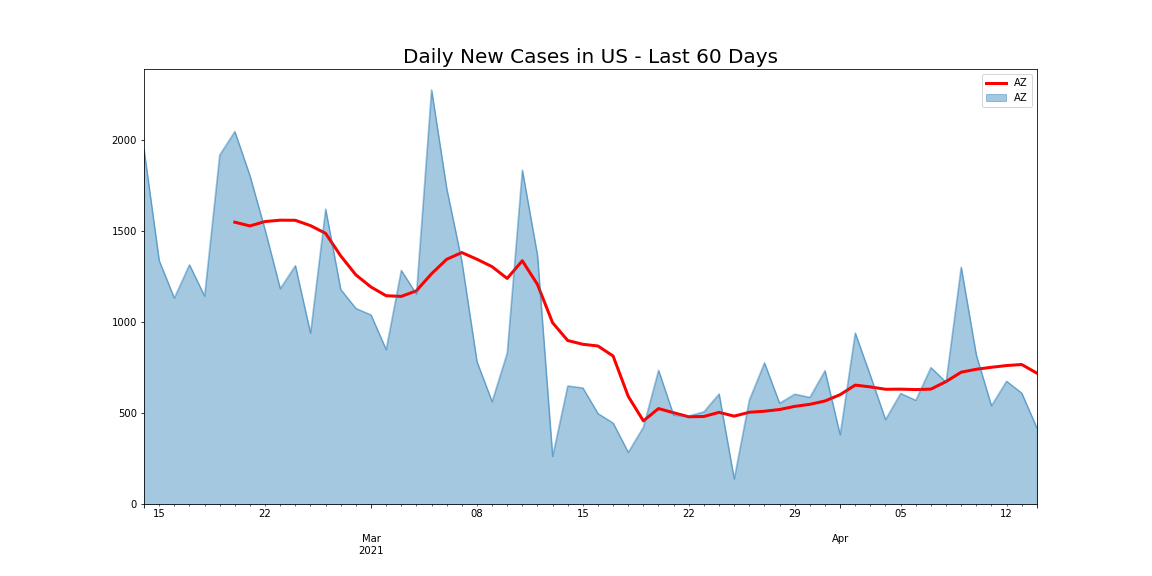

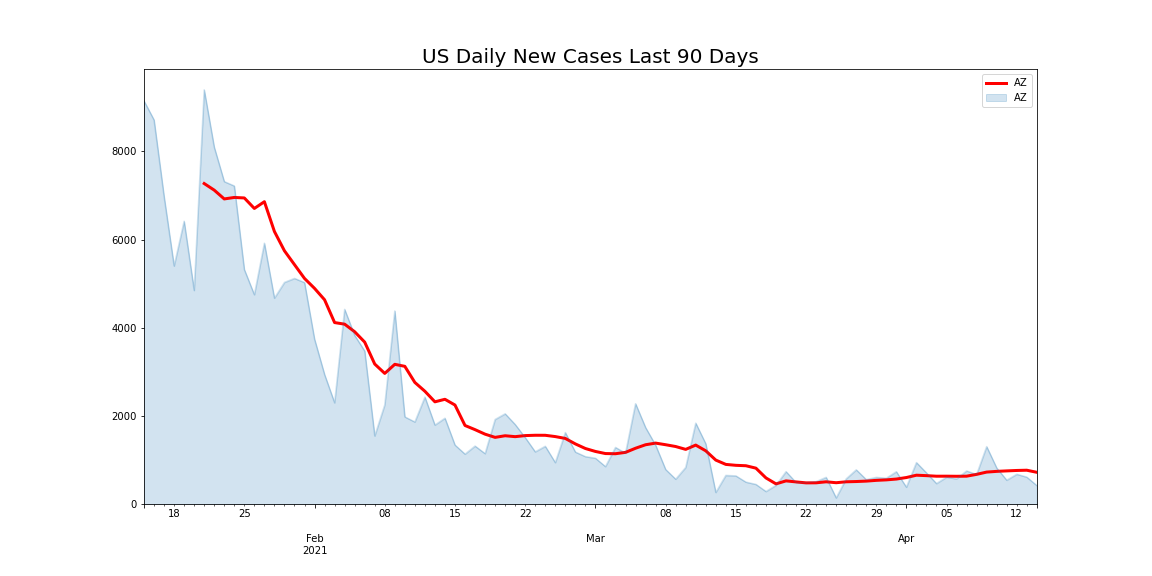

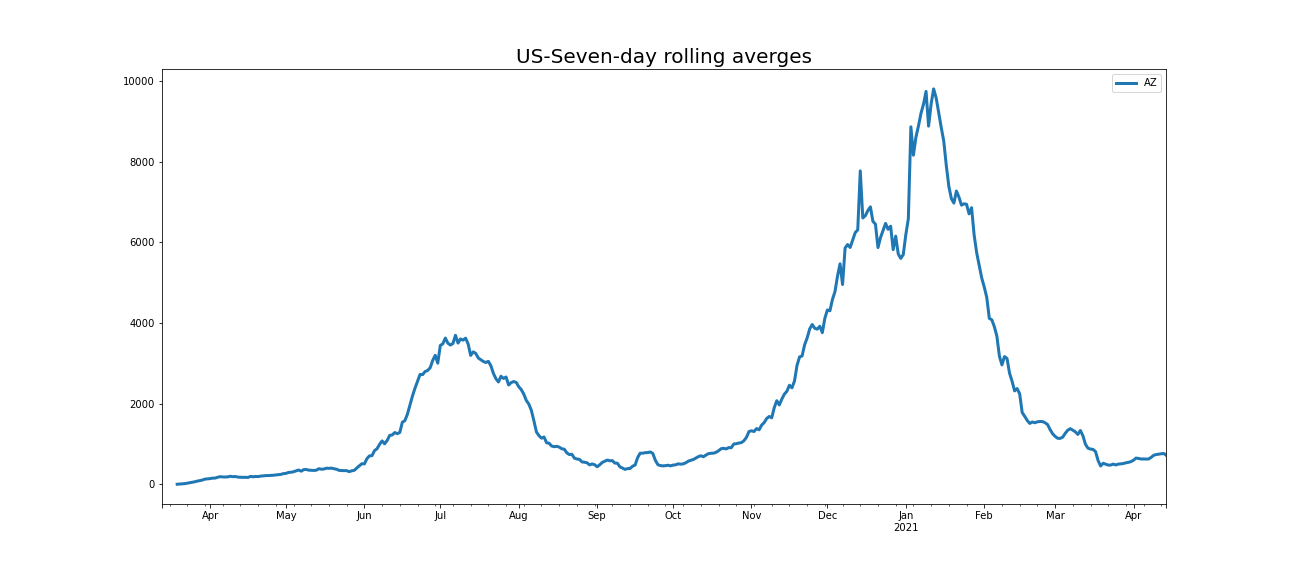

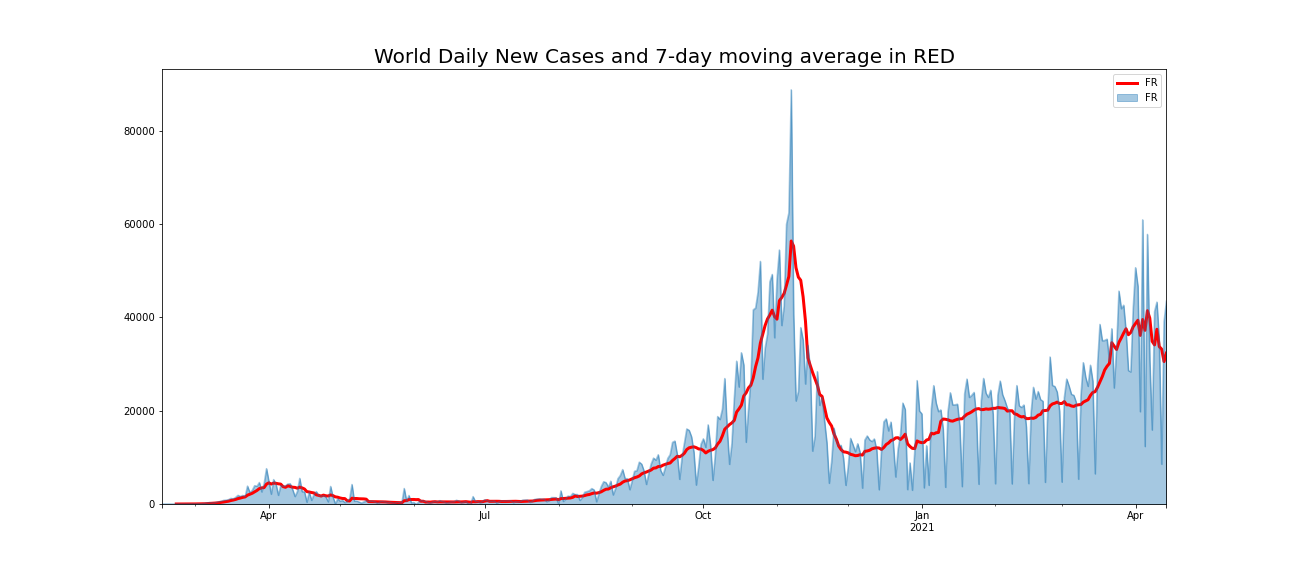

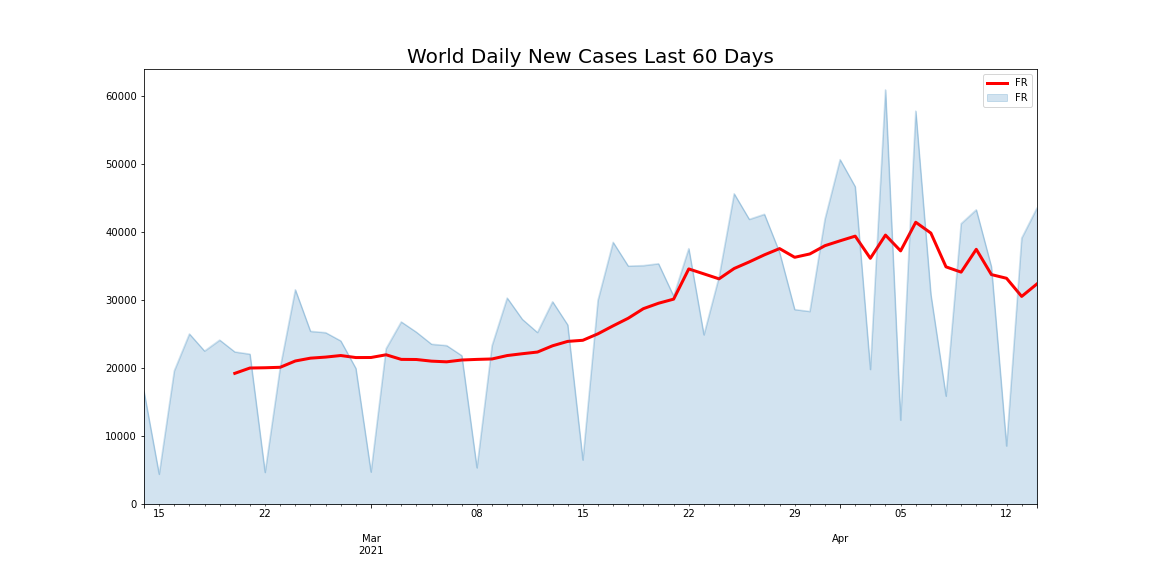

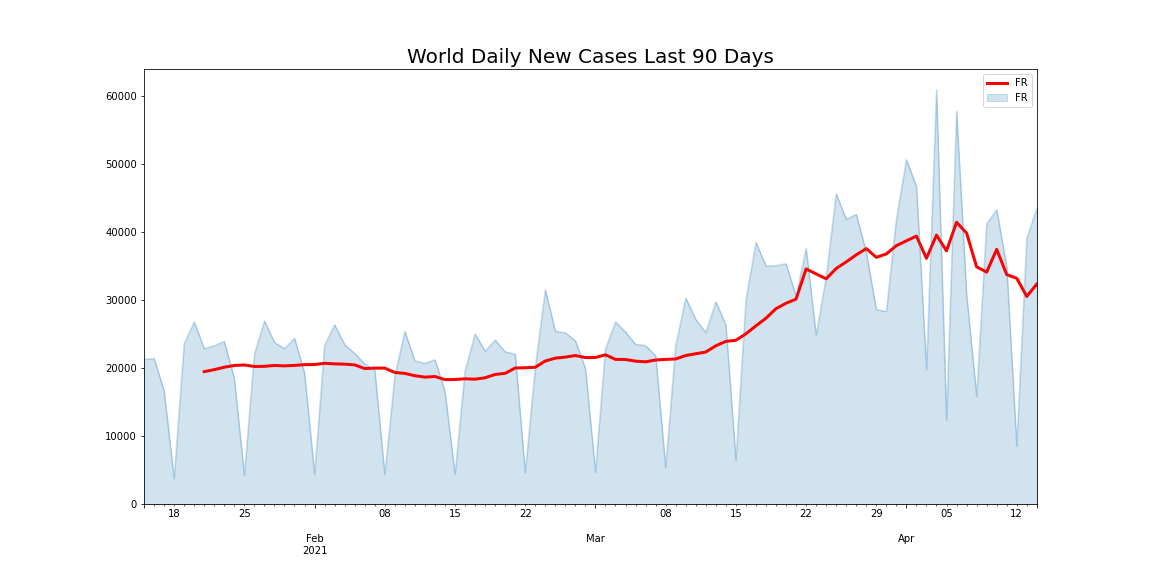

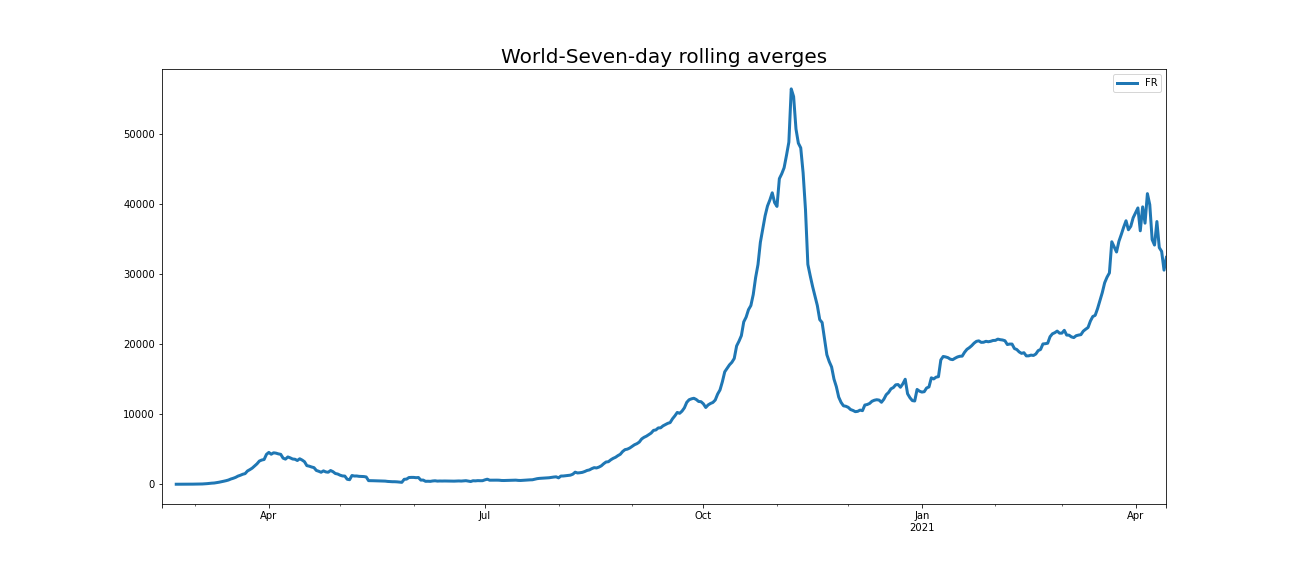

In [69]:
for file in png_list:    
    local = Image(file)
    local

In [70]:
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx

In [71]:
cd ..

/Users/edwardterrell/Desktop/covid_machinations
